# Dog breed identification 
In this project, we will work on building a classifier to identify the breed of a given dog by its image using deep learning and transfer learning, for that, we will be using TensorFlow 2.0 and TensorFlow Hub.

## 1. Problem definition

In this project, we are provided a strictly canine subset of ImageNet in order to practice fine-grained image categorization. How well can we tell the Norfolk Terriers from the Norwich Terriers? 

## 2. Data

The data we will be using is available at : https://www.kaggle.com/competitions/dog-breed-identification/data (it's basically dog images with their respective breeds (labels))

## 3. Evaluation

Submissions are evaluated on Multi Class Log Loss between the predicted probability and the observed target.

## 4. Features

Some information about the data :
* There are 120 dog breeds in this dataset.
* There are over 10000 samples (images) in the training data.
* There are over 10000 samples (images) in the test data.

### Getting our workspace ready by importing the libraries we'll need.


In [2]:
#importing libraries
import pandas as pd
import numpy as np
import tensorflow as tf
import tensorflow_hub as hub
import matplotlib.pyplot as plt

In [ ]:
print("TensorFlow version:",tf.__version__)

TensorFlow version: 2.12.0


### Getting our data ready

In [15]:
#getting a look at the labels 
labels=pd.read_csv("drive/My Drive/Dog breed data/labels.csv")

In [ ]:
labels.head()

id             breed
0  000bec180eb18c7604dcecc8fe0dba07       boston_bull
1  001513dfcb2ffafc82cccf4d8bbaba97             dingo
2  001cdf01b096e06d78e9e5112d419397          pekinese
3  00214f311d5d2247d5dfe4fe24b2303d          bluetick
4  0021f9ceb3235effd7fcde7f7538ed62  golden_retriever

> As we can see, we are provided the breeds in a csv file, which maps every dog image to its breed by the image's id.

<Axes: >

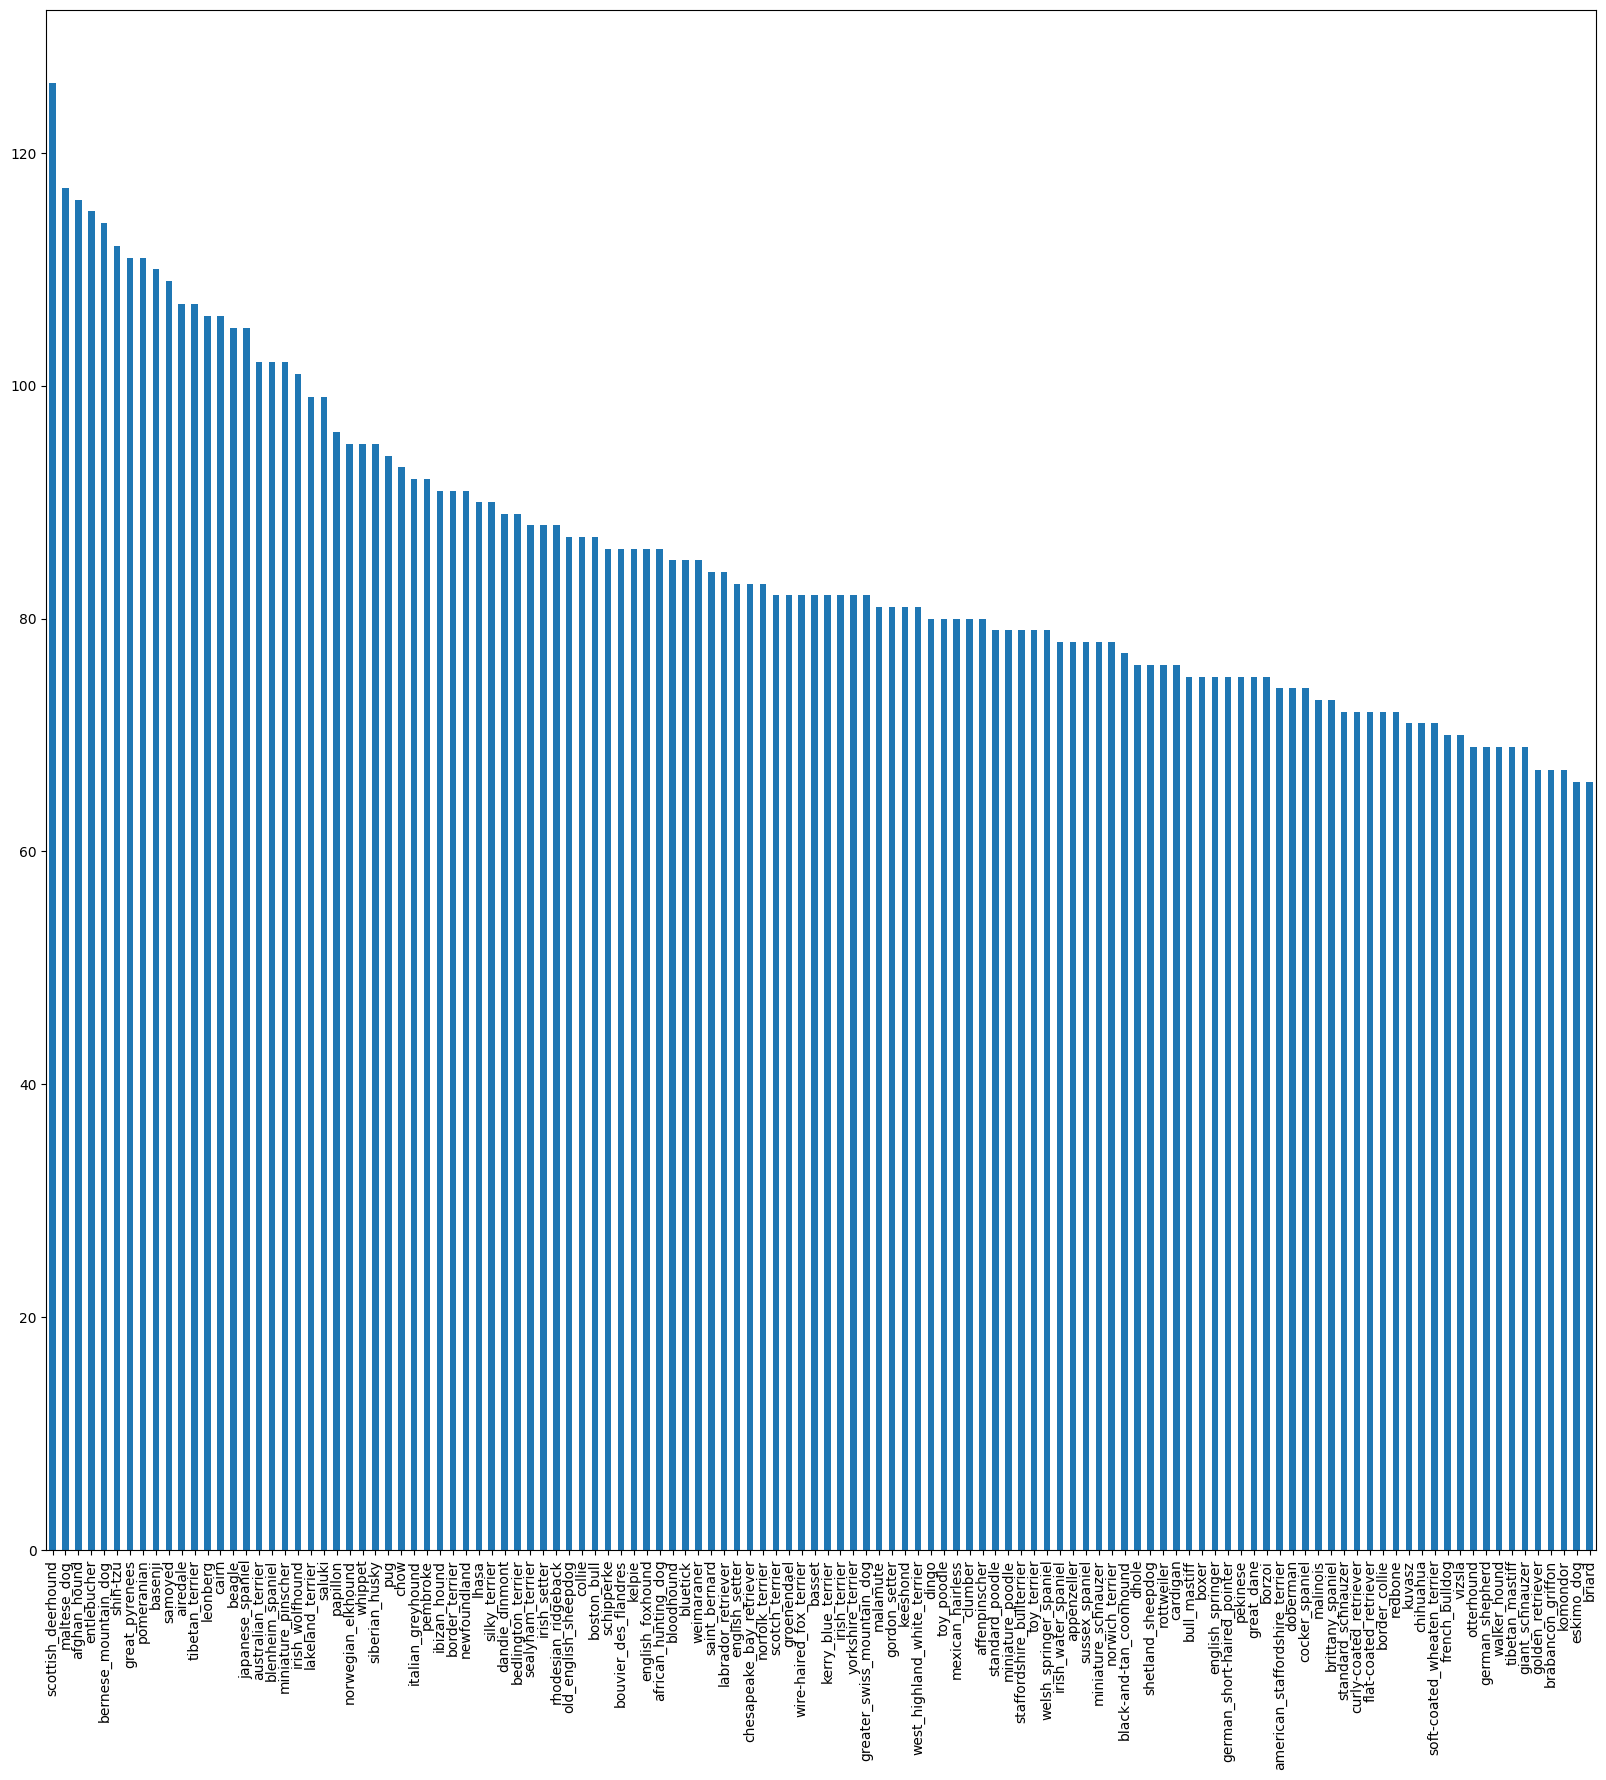

In [ ]:
#checking the distributions of the breeds
labels["breed"].value_counts().plot(kind='bar',figsize=(20,20))

> as we can see, the distribution of the breeds is normal.

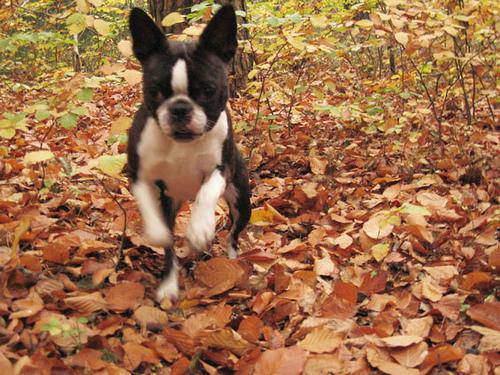

In [ ]:
#getting a look at some of the training images
from IPython.display import Image
Image("drive/My Drive/Dog breed data/train/000bec180eb18c7604dcecc8fe0dba07.jpg")

### Checking our data for inconsistancies

In [ ]:
labels.isna().sum()

id       0
breed    0
dtype: int64

In [ ]:
#checking for inconsistancies in labels
if len(labels["id"])==len(labels["breed"]) :
  print("No inconsistancies in the training labels")
else :
  print("Inconsistancies detected !")

No inconsistancies in the training labels


In [ ]:
#checking for inconsistancies in images
import os
if len(labels["id"])==len(os.listdir("/content/drive/MyDrive/Dog breed data/train/")) :
  print("No inconsistancies in the training images")
else :
  print("Inconsistancies detected !")

No inconsistancies in the training images


Now that we're good to go, it's time to get our data converted into numbers for modelling.

In [ ]:
#making an array of filepaths of images
filepaths=np.array(["drive/My Drive/Dog breed data/train/"+id+".jpg" for id in labels["id"]])
filepaths[:5]

array(['drive/My Drive/Dog breed data/train/000bec180eb18c7604dcecc8fe0dba07.jpg',
       'drive/My Drive/Dog breed data/train/001513dfcb2ffafc82cccf4d8bbaba97.jpg',
       'drive/My Drive/Dog breed data/train/001cdf01b096e06d78e9e5112d419397.jpg',
       'drive/My Drive/Dog breed data/train/00214f311d5d2247d5dfe4fe24b2303d.jpg',
       'drive/My Drive/Dog breed data/train/0021f9ceb3235effd7fcde7f7538ed62.jpg'],
      dtype='<U72')

In [16]:
#turning the labels(breeds) into numbers
#1. getting the unique labels
labels_np=labels["breed"].to_numpy()
unique_labels=np.unique(labels_np)
unique_labels
#2.encoding the unique labels into booleans
encoded_labels=np.array([label==unique_labels for label in labels["breed"]]).astype(int)
encoded_labels[:2]

array([[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0]])

In [ ]:
#create a parameter for sample lenght
NUM_SAMPLES=1000 #@param{type: "slider",min: 1000,max :10000,step : 1000}

In [ ]:
#creating a function that splits our data into valid and training sets
from sklearn.model_selection import train_test_split
X_train,X_valid,y_train,y_valid=train_test_split(filepaths[:NUM_SAMPLES],encoded_labels[:NUM_SAMPLES],random_state=42,test_size=0.2)

In [ ]:
X_train[:3],y_train[:2]

(array(['drive/My Drive/Dog breed data/train/00bee065dcec471f26394855c5c2f3de.jpg',
        'drive/My Drive/Dog breed data/train/0d2f9e12a2611d911d91a339074c8154.jpg',
        'drive/My Drive/Dog breed data/train/1108e48ce3e2d7d7fb527ae6e40ab486.jpg'],
       dtype='<U72'),
 array([[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0,
         0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0

### Preprocessing our images

In [ ]:
#writing a function that preprocesses our images (turn them into tensors)
def preprocess_image(image_path,img_size=224) :
  """
  Turn a given image into a tensor.
  """
  #read the image
  image=tf.io.read_file(image_path)
  #turn it into a numerical tensor
  image=tf.image.decode_jpeg(image,channels=3)
  #scale the image
  image=tf.image.convert_image_dtype(image,tf.float32)
  #resize the image
  image=tf.image.resize(image,size=[img_size,img_size])
  return image


Turning images into batches and getting a <code> (image,label)</code> format

In [ ]:
#writing a function that returns a tuple of format (image,label)
def image_label(image_path,label) :
  return (preprocess_image(image_path),label)

In [ ]:
image_label(X_train[42],tf.constant(y_train[42]))

(<tf.Tensor: shape=(224, 224, 3), dtype=float32, numpy=
 array([[[0.2744866 , 0.20389837, 0.11079565],
         [0.2783996 , 0.19976756, 0.10625179],
         [0.30656803, 0.22681487, 0.13666254],
         ...,
         [0.12188374, 0.12972689, 0.17678571],
         [0.11385673, 0.13132882, 0.1738708 ],
         [0.10720414, 0.13465512, 0.1738708 ]],
 
        [[0.31015828, 0.2395263 , 0.1564482 ],
         [0.29944888, 0.2288911 , 0.14397548],
         [0.35615736, 0.28561288, 0.20727609],
         ...,
         [0.12188374, 0.12972689, 0.17678571],
         [0.12156864, 0.13725491, 0.18039216],
         [0.12156864, 0.13725491, 0.18039216]],
 
        [[0.31448126, 0.24534611, 0.18136677],
         [0.32765028, 0.26288837, 0.19786212],
         [0.28300735, 0.21902803, 0.15713201],
         ...,
         [0.12188374, 0.12972689, 0.17678571],
         [0.11619399, 0.13188025, 0.1750175 ],
         [0.11619399, 0.13188025, 0.1750175 ]],
 
        ...,
 
        [[0.84118253, 0.7941237 

In [ ]:
#writing a function that creates data batches of size 32
BATCH_SIZE=32
def create_data_batches(X,y=None,batch_size=BATCH_SIZE,test_data=False,valid_data=False) :
  """
  Creates data batches of size 32 from given data.
  """
  if test_data :
    data=tf.data.Dataset.from_tensor_slices(tf.constant(X))
    data_batch=data.map(preprocess_image).batch(batch_size)
    print("created test data batches successfully")
    return data_batch
  elif valid_data :
    data=tf.data.Dataset.from_tensor_slices((tf.constant(X),tf.constant(y)))
    data_batch=data.map(image_label).batch(batch_size)
    print("created validation data batches successfully")
    return data_batch
  else :
    data=tf.data.Dataset.from_tensor_slices((tf.constant(X),tf.constant(y)))
    data=data.shuffle(buffer_size=len(X))
    data_batch=data.map(image_label).batch(batch_size)
    print("created training data batches successfully")
    return data_batch

In [ ]:
train_batches=create_data_batches(X_train,y_train)
valid_batches=create_data_batches(X_valid,y_valid,valid_data=True)

created training data batches successfully
created validation data batches successfully


In [ ]:
train_batches.element_spec, valid_batches.element_spec

((TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None),
  TensorSpec(shape=(None, 120), dtype=tf.int64, name=None)),
 (TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None),
  TensorSpec(shape=(None, 120), dtype=tf.int64, name=None)))

### Visualizing our data 

In [ ]:
#visualizing the first 25 images and their labels
import matplotlib.pyplot as plt
def plot_data(images,labels) :
  """
  Plots the images and their labels using matplotlib. 
  """
  plt.figure(figsize=(12,10))
  for i in range(25) :
    ax=plt.subplot(5,5,i+1)
    plt.imshow(images[i])
    plt.title(unique_labels[labels[i].argmax()])
    plt.axis("off")

#### Visualizing the training data

In [ ]:
#unbatching the training data before visualizing it
train_images,train_labels=next(train_batches.as_numpy_iterator())

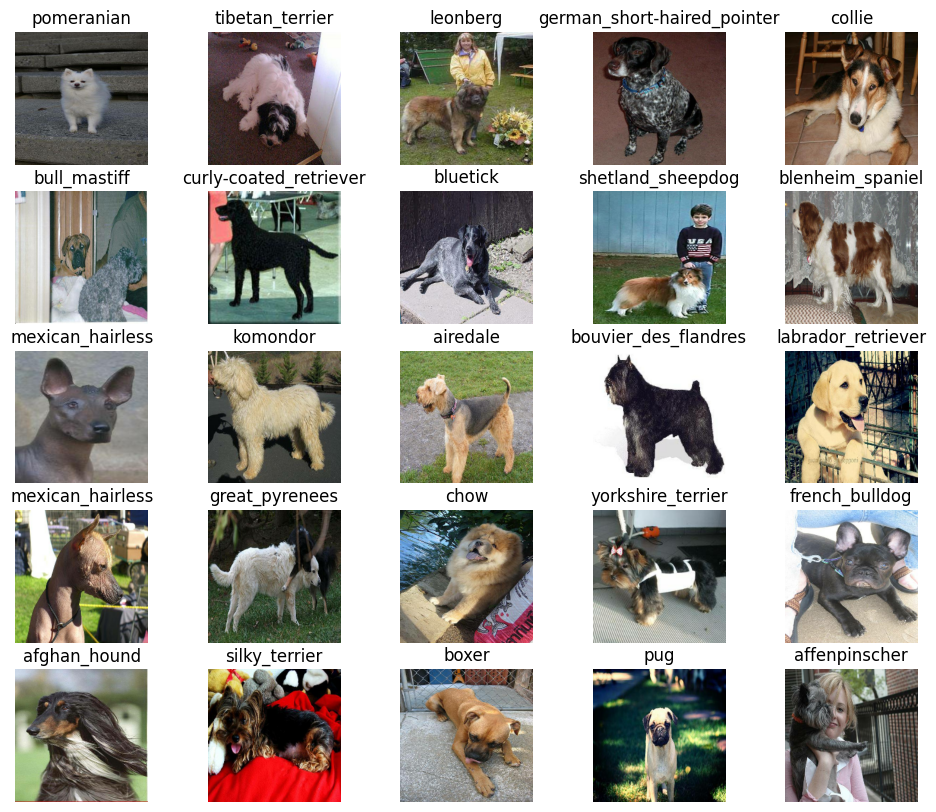

In [ ]:
#plotting the training data
plot_data(train_images,train_labels)

#### Visualizing the validation data 

In [ ]:
#unbatching the data
val_images,val_labels=next(valid_batches.as_numpy_iterator())

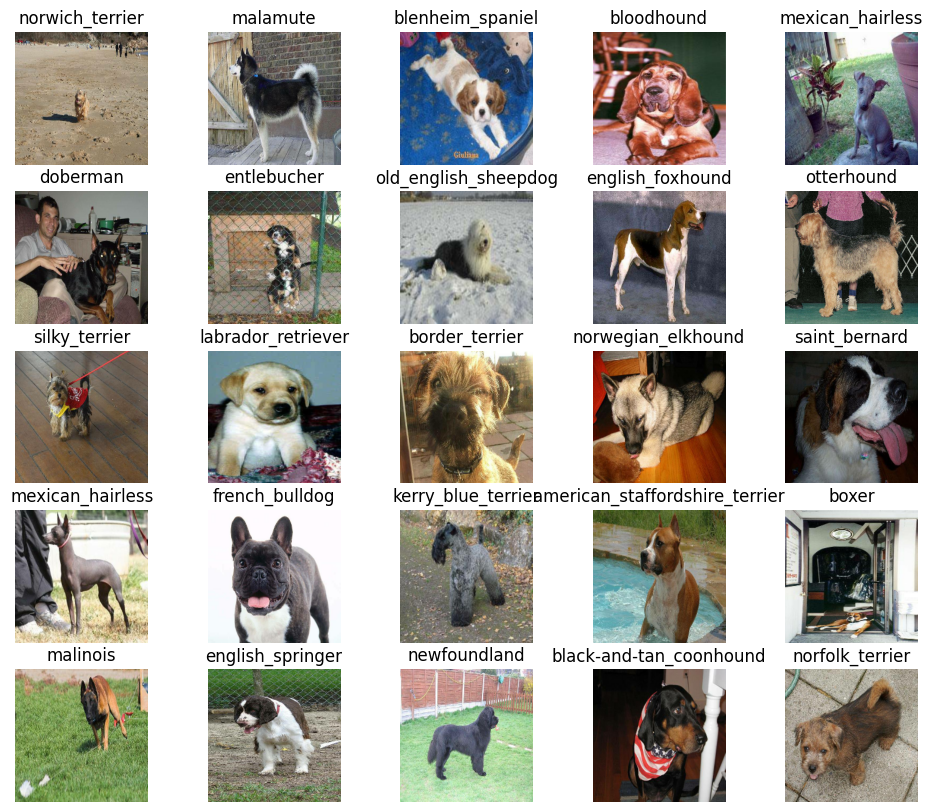

In [ ]:
#plotting the data
plot_data(val_images,val_labels)

### Modelling 

#### Instantiating a model from TensorFlow Hub
In this step, we will setup the inputs shape as long as the outputs shape and we're also going to setup our model's URL from TensorFlow Hub.

In [ ]:
#inputs shape
INPUT_SHAPE=[None,224,224,3]
#Outputs shape
OUTPUT_SHAPE=len(unique_labels)
#model
MODEL_URL="https://tfhub.dev/google/imagenet/mobilenet_v2_130_224/classification/5"

In [ ]:
#creating the function that will build our keras deep learning model
def create_model(input_shape=INPUT_SHAPE,output_shape=OUTPUT_SHAPE,model_url=MODEL_URL) :
  print("building a keras deep learning model with ",model_url)
  #instantiating the model
  model=tf.keras.Sequential([hub.KerasLayer(model_url),tf.keras.layers.Dense(units=output_shape,activation="softmax")])
  #compiling the model
  model.compile(loss=tf.keras.losses.CategoricalCrossentropy(),optimizer=tf.keras.optimizers.Adam(),metrics=["accuracy"])
  #building the model
  model.build(input_shape)
  return model

In [ ]:
model=create_model()
model.summary()

building a keras deep learning model with  https://tfhub.dev/google/imagenet/mobilenet_v2_130_224/classification/5
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 keras_layer (KerasLayer)    (None, 1001)              5432713   
                                                                 
 dense (Dense)               (None, 120)               120240    
                                                                 
Total params: 5,552,953
Trainable params: 120,240
Non-trainable params: 5,432,713
_________________________________________________________________


#### Creating Callbacks

##### Creating a TensorBoard callback

In [ ]:
%load_ext tensorboard

In [ ]:
#function for callback
import datetime
def create_tensorboard_callback() :
    #create a log dir to store the logs generated by tensorboard
    logdir=os.path.join("drive/My Drive/Dog breed data/logs",datetime.datetime.now().strftime("%Y%m%d-%H%M%S"))
    #return the keras tensorboard callback
    return tf.keras.callbacks.TensorBoard(logdir)

In [ ]:
#creating the tensorboard callback
tensorboard=create_tensorboard_callback()

##### Creating an early stopping callback for our model 

In [ ]:
early_stopping=tf.keras.callbacks.EarlyStopping(monitor="val_accuracy",patience=3)

#### Training our model

In [ ]:
#creating a slider for number of epochs 
NUM_EPOCHS=100 #@param {type:"slider",min:10,max:100}

In [ ]:
#create a function that trains the model
def train_model(model) :
  #fit the model
  model.fit(x=train_batches,epochs=NUM_EPOCHS,callbacks=[tensorboard,early_stopping],validation_data=valid_batches)

In [ ]:
train_model(model)

Epoch 1/100
25/25 [==============================] - 168s 6s/step - loss: 4.6922 - accuracy: 0.1050 - val_loss: 3.5000 - val_accuracy: 0.2500
Epoch 2/100
25/25 [==============================] - 3s 121ms/step - loss: 1.7119 - accuracy: 0.6600 - val_loss: 2.1855 - val_accuracy: 0.4750
Epoch 3/100
25/25 [==============================] - 4s 146ms/step - loss: 0.5882 - accuracy: 0.9413 - val_loss: 1.6787 - val_accuracy: 0.5800
Epoch 4/100
25/25 [==============================] - 3s 129ms/step - loss: 0.2560 - accuracy: 0.9937 - val_loss: 1.4710 - val_accuracy: 0.6000
Epoch 5/100
25/25 [==============================] - 3s 121ms/step - loss: 0.1453 - accuracy: 0.9987 - val_loss: 1.3932 - val_accuracy: 0.6000
Epoch 6/100
25/25 [==============================] - 3s 116ms/step - loss: 0.0993 - accuracy: 1.0000 - val_loss: 1.3505 - val_accuracy: 0.6100
Epoch 7/100
25/25 [==============================] - 4s 165ms/step - loss: 0.0754 - accuracy: 1.0000 - val_loss: 1.3182 - val_accuracy: 0.6100


> Our model is overfitting, because we can see that it's performing far better on the training data than it is on the validation data. But in this case, it's a good thing, because it means our model is learning.

#### Visualising the predictions

In [ ]:
#make predictions from validation data
val_preds = model.predict(valid_batches)

7/7 [==============================] - 1s 147ms/step


In [ ]:
#unbatch the validation data
val_images,val_labels=next(valid_batches.as_numpy_iterator())
#visualizing the predictions
def plot_preds(images,preds,labels) :
  """
  Plots the images and wheither the model predicted the label right ot not
  """
  plt.figure(figsize=(20,10))
  for i in range(9) :
    ax=plt.subplot(3,3,i+1)
    plt.imshow(images[i])
    if unique_labels[preds[i].argmax()]==unique_labels[labels[i].argmax()] :
      color="green"
    else :
      color="red"
    plt.title("Predicted : " + unique_labels[preds[i].argmax()] + " , Truth : "+unique_labels[labels[i].argmax()],color=color)
    plt.axis("off")

7/7 [==============================] - 1s 143ms/step


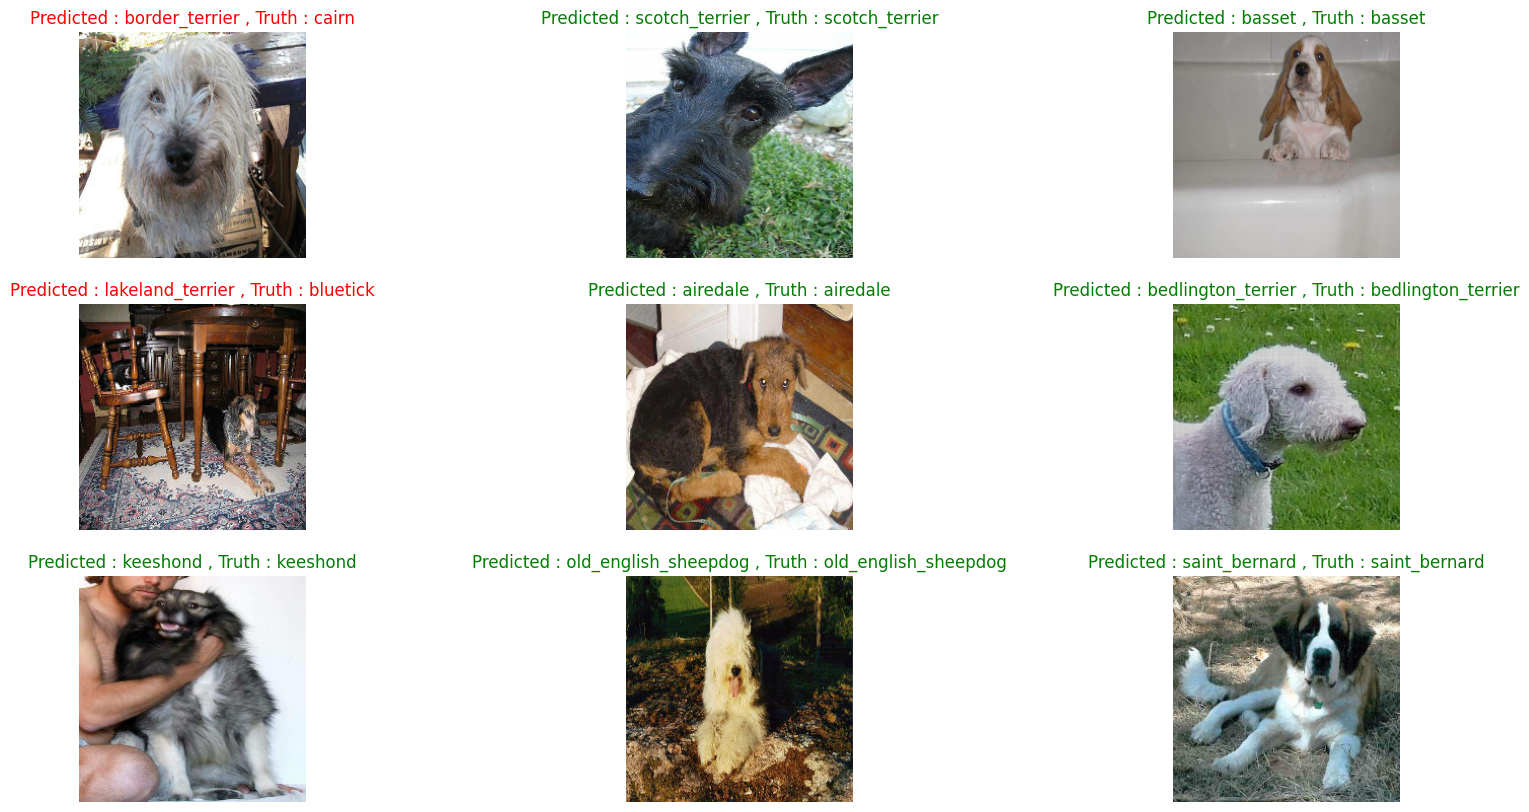

In [ ]:
plot_preds(val_images,val_preds,val_labels)

### Saving our model

In [ ]:
def save_model(model,suffix) :
  model_dir=os.path.join("drive/MyDrive/Dog breed data/models",datetime.datetime.now().strftime("%Y%m%d-%H%M%S"))
  model_path=model_dir+"-"+suffix+".h5"
  print(f"saving our model to :{model_path} ...")
  model.save(model_path)
  return model_path

In [ ]:
def load_model(model_path) :
  print(f"loading our model from {model_path} ...")
  model=tf.keras.models.load_model(model_path,custom_objects={"KerasLayer" :hub.KerasLayer})
  return model

In [ ]:
#saving a model
model_path=save_model(model,"1000-images-mobilenetv2-Adam")

saving our model to :drive/MyDrive/Dog breed data/models/20230605-010539-1000-images-mobilenetv2-Adam.h5 ...


### Training a model on the full dataset

In [ ]:
#creating a full data batch
full_data=create_data_batches(X=filepaths,y=encoded_labels)

created training data batches successfully


In [ ]:
#creating a model
full_model=create_model()

building a keras deep learning model with  https://tfhub.dev/google/imagenet/mobilenet_v2_130_224/classification/5


In [ ]:
#creating callbacks
#1. tensorboard callback
full_model_tb_callback=create_tensorboard_callback()
#2. Early stopping
full_model_early_stopping=tf.keras.callbacks.EarlyStopping(monitor="accuracy",patience=3)

In [ ]:
#fitting the model
full_model.fit(x=full_data,epochs=NUM_EPOCHS,callbacks=[full_model_tb_callback,full_model_early_stopping])

Epoch 1/100
320/320 [==============================] - 1194s 4s/step - loss: 1.2273 - accuracy: 0.6867
Epoch 2/100
320/320 [==============================] - 37s 114ms/step - loss: 0.3941 - accuracy: 0.8861
Epoch 3/100
320/320 [==============================] - 35s 110ms/step - loss: 0.2339 - accuracy: 0.9349
Epoch 4/100
320/320 [==============================] - 36s 114ms/step - loss: 0.1498 - accuracy: 0.9648
Epoch 5/100
320/320 [==============================] - 36s 111ms/step - loss: 0.1055 - accuracy: 0.9780
Epoch 6/100
320/320 [==============================] - 36s 114ms/step - loss: 0.0767 - accuracy: 0.9877
Epoch 7/100
320/320 [==============================] - 37s 116ms/step - loss: 0.0564 - accuracy: 0.9918
Epoch 8/100
320/320 [==============================] - 37s 115ms/step - loss: 0.0461 - accuracy: 0.9940
Epoch 9/100
320/320 [==============================] - 37s 115ms/step - loss: 0.0382 - accuracy: 0.9954
Epoch 10/100
320/320 [==============================] - 35s 109ms

In [ ]:
#saving the trained full model 
full_model_path=save_model(full_model,"full-data-mobilenetv2-Adam")

saving our model to :drive/MyDrive/Dog breed data/models/20230605-215511-full-data-mobilenetv2-Adam.h5 ...


### Evaluating the model on the test data and submitting the results to kaggle

#### Making the predictions

In [ ]:
#creating the test data filepaths
test_filepaths=np.array(["drive/My Drive/Dog breed data/test/"+name for name in os.listdir("drive/My Drive/Dog breed data/test")])
test_filepaths[:5]

array(['drive/My Drive/Dog breed data/test/ddfe1bb4884e83421872030ac62835f1.jpg',
       'drive/My Drive/Dog breed data/test/df0196ea5d16d1570c1f2b567b975b90.jpg',
       'drive/My Drive/Dog breed data/test/dd3ac0ab0e9328f1f4c1692947c17c09.jpg',
       'drive/My Drive/Dog breed data/test/ddbdd621e79563a56443a0dd1ee4c48d.jpg',
       'drive/My Drive/Dog breed data/test/dd1eddb779b2611cdd42de48ae623a62.jpg'],
      dtype='<U71')

In [ ]:
#creating the test data batches
test_data=create_data_batches(test_filepaths,test_data=True)

created test data batches successfully


In [ ]:
test_data.element_spec

TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None)

In [ ]:
predictions=full_model.predict(test_data)
predictions[:2]

324/324 [==============================] - 1177s 4s/step


array([[3.42944839e-10, 2.18942532e-07, 3.39330768e-08, 1.34860997e-07,
        9.33481942e-07, 2.22369067e-06, 7.36353867e-10, 8.14936527e-08,
        4.45882620e-09, 1.33528415e-08, 9.02600550e-10, 6.56747403e-08,
        2.20063176e-10, 1.34322863e-06, 3.10973441e-10, 3.41103964e-06,
        1.46677746e-06, 6.37905617e-10, 2.29561101e-06, 1.11662439e-06,
        1.53604546e-10, 5.66985614e-09, 7.51917209e-11, 2.22490790e-10,
        3.26517900e-03, 1.08454152e-08, 2.82195778e-09, 1.14816892e-07,
        3.04929308e-08, 1.38108298e-08, 4.07547347e-08, 5.49724234e-07,
        4.85829107e-04, 2.11740658e-03, 4.85986675e-07, 5.35090527e-10,
        7.87928123e-09, 6.37941852e-11, 1.39533529e-09, 3.94892226e-07,
        2.18994147e-03, 9.76620674e-01, 3.89969046e-07, 1.62527380e-10,
        2.91416291e-06, 1.07625027e-10, 7.95881278e-11, 5.32079372e-04,
        2.19038587e-09, 4.02952782e-09, 7.74366171e-08, 1.66639580e-09,
        6.48219789e-09, 1.07281693e-07, 1.40267864e-09, 6.506563

#### Visualizing the predictions

In [ ]:
#converting the predicted probablities into labels
test_labels=[]
for i in range(len(predictions)) :
    test_labels.append(unique_labels[predictions[i].argmax()])

In [ ]:
#getting the test images ready
test_images=next(test_data.as_numpy_iterator())

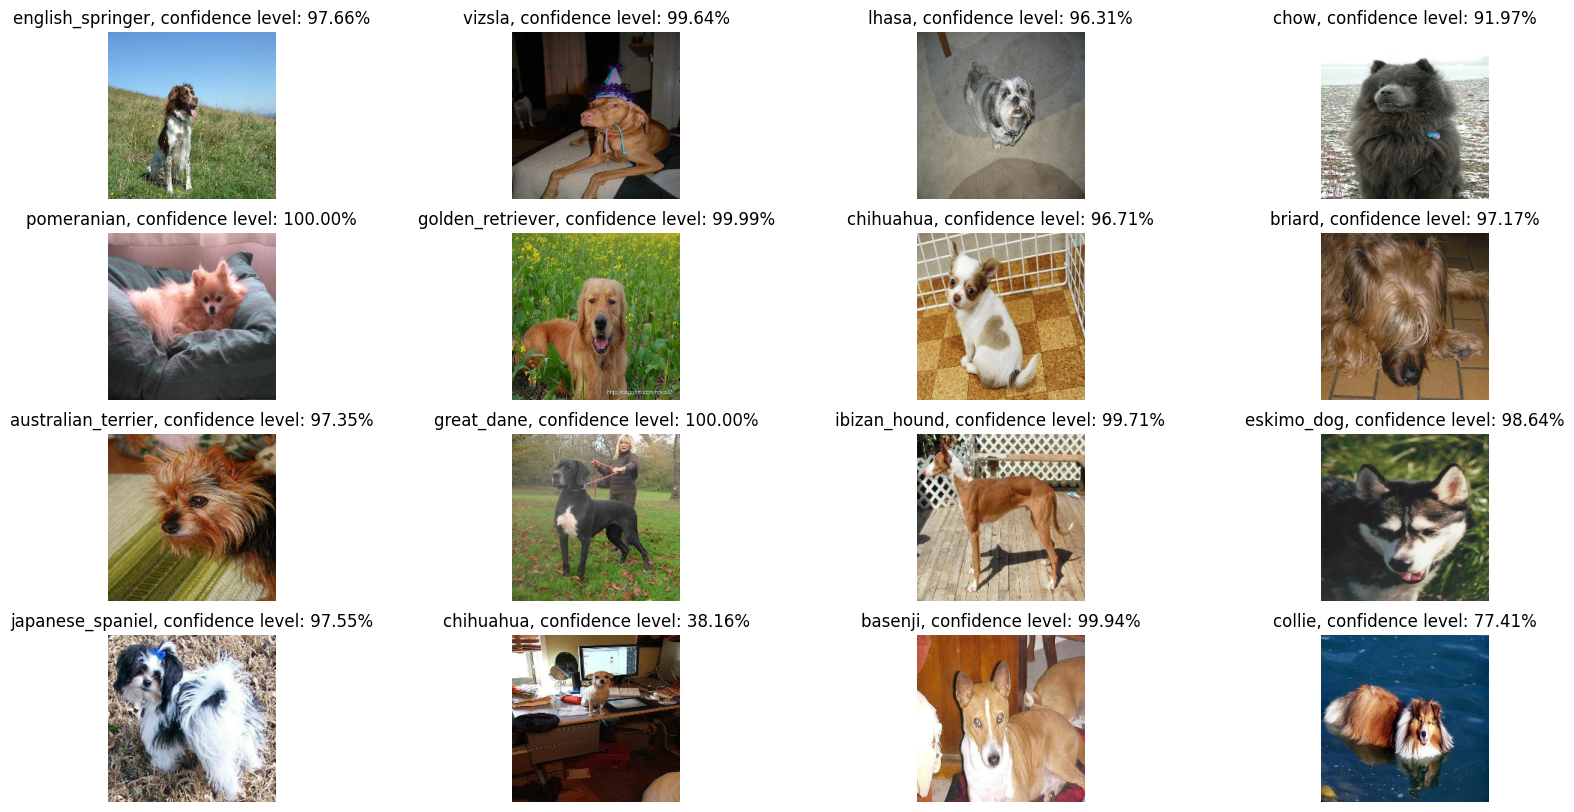

In [ ]:
### Visualizing the predictions
plt.figure(figsize=(20,10))
for i in range(16) :
  ax=plt.subplot(4,4,i+1)
  plt.imshow(test_images[i])
  plt.title(test_labels[i]+str(", confidence level: ")+"%.2f"%(predictions[i].max()*100)+"%")
  plt.axis("off")

#### Getting the predictions in kaggle submission's format




In [ ]:
#rounding the predictions to 6 decimal places
def round_val(value) :
  return float("%.6f"%(value,))

round_val=np.vectorize(round_val)
test_preds=round_val(predictions)

In [ ]:
#extracting the id from the images' paths
ids=[pt.split(".")[0] for pt in os.listdir("drive/My Drive/Dog breed data/test")]

In [ ]:
#making the kaggle submission dataframe
kaggle_submission=pd.concat([pd.DataFrame(ids,columns=["id"]),pd.DataFrame(predictions,columns=unique_labels)],axis=1)
kaggle_submission.head()

id  affenpinscher  afghan_hound  \
0  ddfe1bb4884e83421872030ac62835f1   3.429448e-10  2.189425e-07   
1  df0196ea5d16d1570c1f2b567b975b90   4.534692e-11  1.788832e-10   
2  dd3ac0ab0e9328f1f4c1692947c17c09   1.651976e-08  2.749159e-12   
3  ddbdd621e79563a56443a0dd1ee4c48d   2.787949e-07  1.003863e-08   
4  dd1eddb779b2611cdd42de48ae623a62   3.317416e-11  5.918848e-13   

   african_hunting_dog      airedale  american_staffordshire_terrier  \
0         3.393308e-08  1.348610e-07                    9.334819e-07   
1         2.806462e-13  1.126578e-07                    2.562210e-08   
2         8.902542e-11  3.201341e-13                    6.048610e-10   
3         1.327622e-08  1.776792e-07                    7.547726e-09   
4         3.150115e-13  4.693438e-15                    1.034362e-12   

    appenzeller  australian_terrier       basenji        basset  ...  \
0  2.223691e-06        7.363539e-10  8.149365e-08  4.458826e-09  ...   
1  7.400557e-10        2.722908e-06  6.658939e-11  4.984678e-12  ...   
2  1.052531e-11        2.313949e-10  1.305920e-09  2.983355e-07  ...   
3  8.425146e-08        4.104133e-07  3.406139e-08  1.812634e-08  ...   
4  5.516925e-15        1.825102e-09  9.293280e-12  3.860700e-16  ...   

     toy_poodle   toy_terrier        vizsla  walker_hound    weimaraner  \
0  1.107051e-07  4.199503e-09  1.952965e-07  5.353596e-06  2.199816e-08   
1  1.549502e-07  6.361035e-08  9.963961e-01  1.384498e-09  2.568207e-09   
2  1.291145e-08  4.028182e-10  8.227363e-12  1.860627e-10  1.892176e-08   
3  1.043937e-07  1.120027e-08  1.154296e-08  7.619198e-08  4.707160e-06   
4  9.867133e-11  1.135247e-11  1.378756e-13  6.688586e-14  1.318738e-13   

   welsh_springer_spaniel  west_highland_white_terrier       whippet  \
0            1.470202e-02                 3.581702e-09  1.111239e-06   
1            4.111513e-13                 2.728364e-15  6.509222e-09   
2            1.773834e-11                 9.569843e-09  2.255967e-10   
3            2.385898e-10                 8.052709e-09  1.449035e-09   
4            1.005097e-16                 1.569961e-13  2.487935e-15   

   wire-haired_fox_terrier  yorkshire_terrier  
0             9.492085e-10       7.720739e-09  
1             9.503451e-09       7.646269e-08  
2             2.435194e-11       3.074763e-08  
3             3.827206e-09       2.107801e-10  
4             1.005935e-13       8.781335e-11  

[5 rows x 121 columns]

In [ ]:
#comparing it to the sample submission file
pd.read_csv("drive/My Drive/Dog breed data/sample_submission.csv").head()

id  affenpinscher  afghan_hound  \
0  000621fb3cbb32d8935728e48679680e       0.008333      0.008333   
1  00102ee9d8eb90812350685311fe5890       0.008333      0.008333   
2  0012a730dfa437f5f3613fb75efcd4ce       0.008333      0.008333   
3  001510bc8570bbeee98c8d80c8a95ec1       0.008333      0.008333   
4  001a5f3114548acdefa3d4da05474c2e       0.008333      0.008333   

   african_hunting_dog  airedale  american_staffordshire_terrier  appenzeller  \
0             0.008333  0.008333                        0.008333     0.008333   
1             0.008333  0.008333                        0.008333     0.008333   
2             0.008333  0.008333                        0.008333     0.008333   
3             0.008333  0.008333                        0.008333     0.008333   
4             0.008333  0.008333                        0.008333     0.008333   

   australian_terrier   basenji    basset  ...  toy_poodle  toy_terrier  \
0            0.008333  0.008333  0.008333  ...    0.008333     0.008333   
1            0.008333  0.008333  0.008333  ...    0.008333     0.008333   
2            0.008333  0.008333  0.008333  ...    0.008333     0.008333   
3            0.008333  0.008333  0.008333  ...    0.008333     0.008333   
4            0.008333  0.008333  0.008333  ...    0.008333     0.008333   

     vizsla  walker_hound  weimaraner  welsh_springer_spaniel  \
0  0.008333      0.008333    0.008333                0.008333   
1  0.008333      0.008333    0.008333                0.008333   
2  0.008333      0.008333    0.008333                0.008333   
3  0.008333      0.008333    0.008333                0.008333   
4  0.008333      0.008333    0.008333                0.008333   

   west_highland_white_terrier   whippet  wire-haired_fox_terrier  \
0                     0.008333  0.008333                 0.008333   
1                     0.008333  0.008333                 0.008333   
2                     0.008333  0.008333                 0.008333   
3                     0.008333  0.008333                 0.008333   
4                     0.008333  0.008333                 0.008333   

   yorkshire_terrier  
0           0.008333  
1           0.008333  
2           0.008333  
3           0.008333  
4           0.008333  

[5 rows x 121 columns]

In [ ]:
#saving our submission to a csv file
kaggle_submission.to_csv("drive/My Drive/Dog breed data/Anass_el_mansouri_kaggle_submission_for_DBI_mobilenetv2.csv",index=False)

> As can be seen on the probablities of predictions made by our model, it seems to be very confident on its choices, and the labels of the images plotted were correctly predicted, so i think our model is doing a great job !!!

### Extra section : making predictions on custom data 

In [ ]:
#getting the filepaths of the custom images
custom_data_filepaths=["drive/My Drive/Dog breed data/custom/"+fname for fname in os.listdir("drive/My Drive/Dog breed data/custom")]
custom_data_filepaths

['drive/My Drive/Dog breed data/custom/0f29389283989238983o801.jpg',
 'drive/My Drive/Dog breed data/custom/019209109201902f.jpg',
 'drive/My Drive/Dog breed data/custom/1bcb46815dee4e6a8733893be53b604b.jpg',
 'drive/My Drive/Dog breed data/custom/847ee4a5c402405bb329a4501037bd0b.jpg']

In [ ]:
custom_data_labels=["welsh_springer_spaniel","pomeranian","old_english_sheepdog","silky_terrier"]

In [ ]:
#create custom data batches
custom_data=create_data_batches(X=custom_data_filepaths,test_data=True)

created test data batches successfully


In [ ]:
custom_data_predictions=full_model.predict(custom_data)

1/1 [==============================] - 2s 2s/step


In [ ]:
custom_data_predicted_labels=[unique_labels[custom_data_prediction.argmax()] for custom_data_prediction in custom_data_predictions]

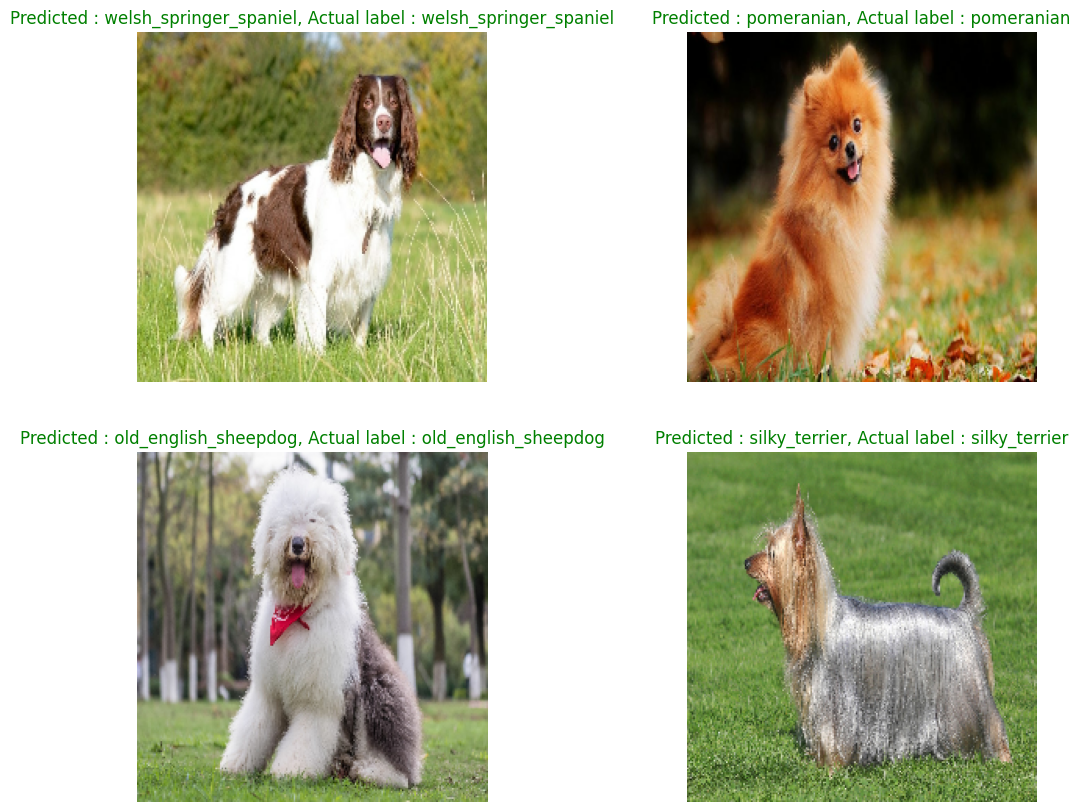

In [ ]:
#plotting the predictions
plt.figure(figsize=(13,10))
true=0
for i in range(4) :
  ax=plt.subplot(2,2,i+1)
  plt.imshow(next(custom_data.as_numpy_iterator())[i])
  if custom_data_predicted_labels[i]==custom_data_labels[i] :
    true+=1
    color="green"
  else :
    color="red"
  plt.title("Predicted : "+custom_data_predicted_labels[i]+", Actual label : "+custom_data_labels[i],color=color)
  plt.axis("off")

In [ ]:
print(f"accuracy : {true/4*100}%")

accuracy : 100.0%


Making a confusion matrix

In [11]:
predictions=pd.read_csv("/content/drive/MyDrive/Dog breed data/Anass_el_mansouri_kaggle_submission_for_DBI_mobilenetv2.csv").drop("id",axis=1).to_numpy()
#formatting the test predictions
cm_preds=np.array([(prediction.argmax()+1) for prediction in predictions])
cm_preds

array([ 42, 113,  71, ...,  45,  61,  24])

In [12]:
test_preds=cm_preds

In [18]:
from sklearn.metrics import ConfusionMatrixDisplay
ConfusionMatrixDisplay.from_predictions(test_preds,cm_preds,labels=unique_labels)

TypeError: ignored